Image Classification Train method (train and test)

# Imports

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf
# import keras
print("Reg Train TF version: ", tf.__version__)
# print("Reg Train Keras version: ", keras.__version__)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import cv2 as cv
import math
import os
import time
import pickle

import zipfile
from imageio import imread
# from skimage.io import imread
from skimage.transform import resize
import pprint


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from utils import preprocess_data, next_batch, calculate_accuracy
from model import Model

Reg Train TF version:  2.6.0
2.6.0


ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

# Constants and Settings

In [2]:
# Settings/parameters to be used later

# Constants
# Image sizes vary between 15x15 to 250x250 pixels
IMG_SIZE = 32  # square image of size IMG_SIZE x IMG_SIZE
GRAYSCALE = False  # convert image to grayscale?
NUM_CHANNELS = 1 if GRAYSCALE else 3
NUM_CLASSES = 43

# Model parameters
LR = 1e-4  # learning rate
KEEP_PROB = 0.5  # dropout keep probability
RATE = 1 - KEEP_PROB
# OPT = tf.train.GradientDescentOptimizer(learning_rate=LR)  # choose which optimizer to use
OPT = tf.optimizers.SGD(learning_rate=LR, momentum = 0, nesterov = False, name='SGD')

# Training process
RESTORE = False  # restore previous model, don't train?
RESUME = False  # resume training from previously trained model?

NUM_EPOCH = 200
coef = 0.00005

BATCH_SIZE = 128  # batch size for training (relatively small)
BATCH_SIZE_INF = 2048  # batch size for running inference, e.g. calculating accuracy
VALIDATION_SIZE = 0.2  # fraction of total training set to use as validation set
SAVE_MODEL = True  # save trained model to disk?
MODEL_SAVE_PATH = './model.ckpt'  # where to save trained model

# Import Dataset

In [3]:
import urllib.request
import os.path
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    # Get file from URL
    url = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html"
    filename = "./GTSRB_Final_Training_Images.zip"
    urllib.request.urlretrieve(url, filename)
    

In [4]:
TEST_SIZE = 0.2        # fraction of total training set to use as test set
VALIDATION_SIZE = 0.2  # fraction of remaining training set to use as validation set

X, Xt, y, yt = list(), list(), list(), list()

archive = zipfile.ZipFile('./GTSRB_Final_Training_Images.zip', 'r')

file_paths = [file for file in archive.namelist() 
              if '.ppm' in file]

for filename in file_paths:
    with archive.open(filename) as img_file:

        img = imread(img_file.read())
        img = resize(img,
                     output_shape=(IMG_SIZE, IMG_SIZE),
                     mode='reflect',
                     anti_aliasing=True
                    )
        img_class = int(filename.split('/')[-2])
        

#     img = imread(archive.open(filename))
#     img = resize(img,
#                  output_shape=(IMG_SIZE, IMG_SIZE),
#                  mode='reflect',
#                  anti_aliasing=True
#                 )
#     img_class = int(filename.split('/')[-2])

    if (hash(filename) % 1000) / 1000 > TEST_SIZE:
        X.append(img)
        y.append(img_class)
    else:
        Xt.append(img)
        yt.append(img_class)
archive.close()
    
# # Load pickled data
# with open('train_aug.p', mode='rb') as f:
#     train = pickle.load(f)

# X_train, y_train = train['features'], train['labels']
# X_train, y_train = preprocess_data(X_train, y_train)

# with open('test.p', mode='rb') as f:
#     test = pickle.load(f)
# X_test, y_test = test['features'], test['labels']
# X_test, y_test = preprocess_data(X_test, y_test)




In [8]:
#Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(np.asarray(X), np.asarray(y), test_size=VALIDATION_SIZE)
X_test = np.asarray(Xt)
y_test = np.asarray(yt)

1. Loading the data
Two files are existed.
train.p is images for training method
test.p is images for testing training method

No classes:43


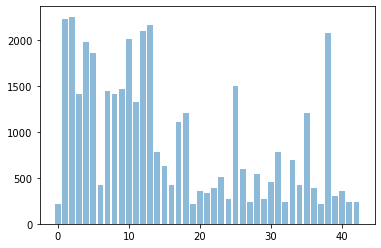

In [9]:
test_ratio = len(Xt) / len(file_paths)
# print("Train size: {} test size: {} ({:0.3f})").format(
#     len(X), 
#     len(Xt),
#     test_ratio)

classes, dist = np.unique(y+yt, return_counts = True)
NUM_CLASSES = len(classes)
print("No classes:{}".format(NUM_CLASSES))

plt.bar(classes, dist, align = 'center', alpha = 0.5)
plt.show()

X_train shape: (25105, 32, 32, 3)
y_train shape: (25105,)
X_valid shape: (6277, 32, 32, 3)
y_valid shape: (6277,)
X_test shape: (7827, 32, 32, 3)
y_test shape: (7827,)


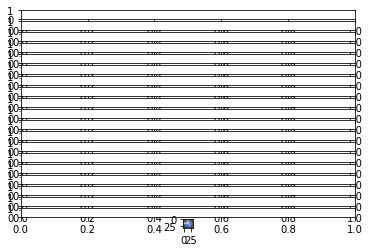

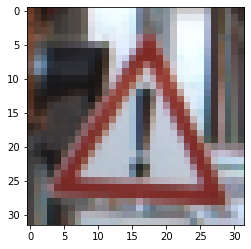

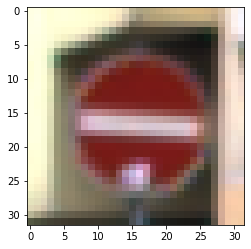

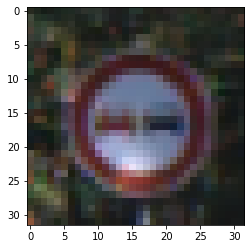

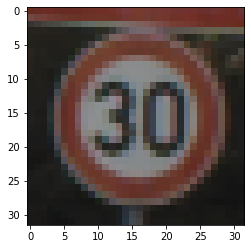

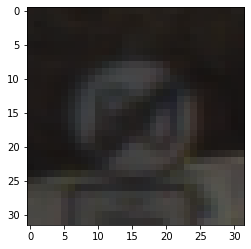

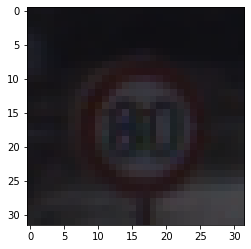

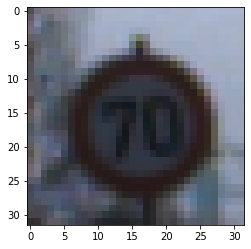

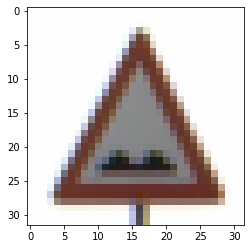

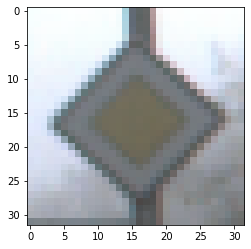

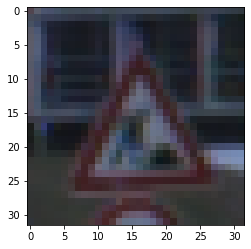

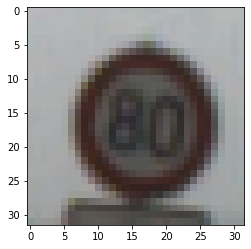

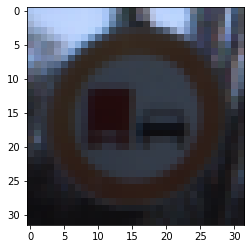

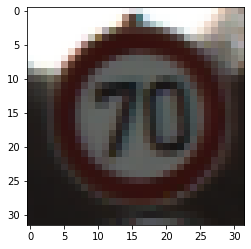

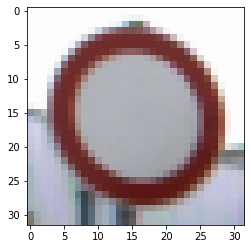

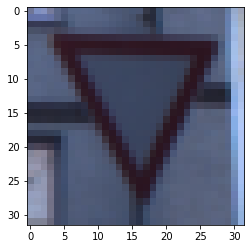

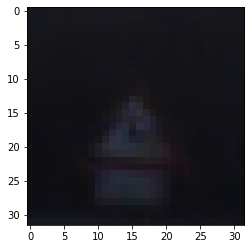

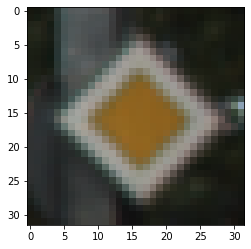

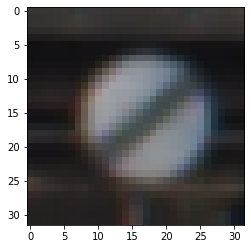

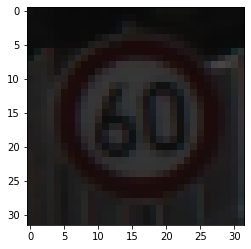

In [10]:
# import pickle

# training_file = "./train.p"
# testing_file = "./test.p"

# with open(training_file, mode='rb') as f:
#     train = pickle.load(f)
# with open(testing_file, mode='rb') as f:
#     test = pickle.load(f)
    
# X_train, y_train = train['features'], train['labels']
# X_test, y_test = test['features'], test['labels']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

imgs = X_valid
f, imgplot = plt.subplots(20)

for i in range(20):
    img = imgs[i]
    imgplot[i] = plt.imshow(img)
    plt.show()
    

2.Dataset Summary & Exploration

Show the number of dataset, shape, and number of classes

In [11]:
import numpy as np
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 25105
Number of testing examples = 7827
Image data shape = (32, 32, 3)
Number of classes = 43


Visualization the dataset
Show 10 randome data from train.p files

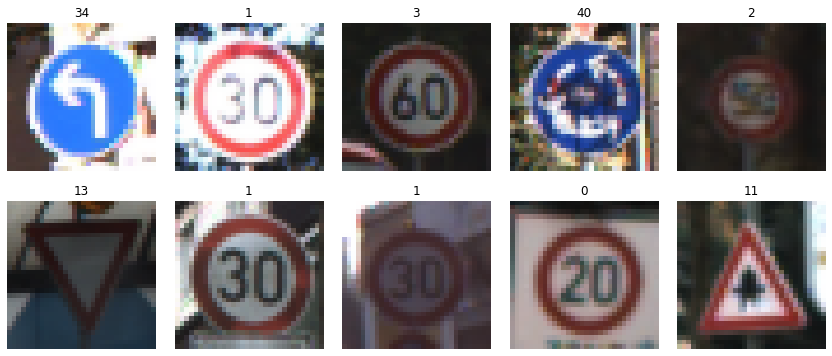

In [12]:
#Visualization the dataset
import matplotlib.pyplot as plt
import random
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

3.Preprocessing (This should be modified in the future.)

In this method, two preprocessing will be applied
1. Turning all train images to grayscale - turning grayscale will reduce train time and helpful if we don't have GPU
since Jetson Nano has GPU, we can remove the grayscale preprocessing in the future.
2. Nomarlization

Converting to data image to gray scale

In [13]:
# Convert to grayscale
X_train_rgb = X_train
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)

X_test_rgb = X_test
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

print('RGB shape:', X_train_rgb.shape)
print('Grayscale shape:', X_train_gry.shape)

RGB shape: (25105, 32, 32, 3)
Grayscale shape: (25105, 32, 32, 1)


In [14]:
X_train = X_train_gry
X_test = X_test_gry

print('Done')

Done


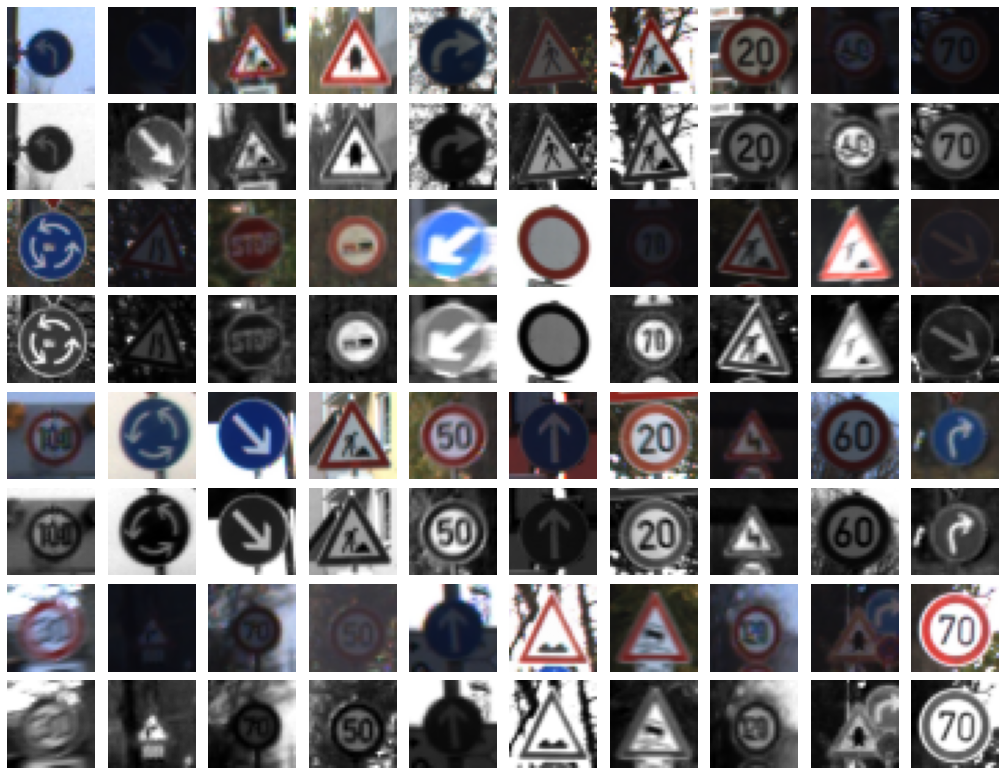

In [15]:
# Show how to change to grayscale
n_rows = 8
n_cols = 10
offset = 9000
fig, axs = plt.subplots(n_rows,n_cols, figsize=(18, 14))
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()
for j in range(0,n_rows,2):
    for i in range(n_cols):
        index = i + j*n_cols
        image = X_train_rgb[index + offset]
        axs[index].axis('off')
        axs[index].imshow(image)
    for i in range(n_cols):
        index = i + j*n_cols + n_cols 
        image = X_train_gry[index + offset - n_cols].squeeze()
        axs[index].axis('off')
        axs[index].imshow(image, cmap='gray')

-0.9974830526953768
-0.9974731326925163
Original shape: (25105, 32, 32, 1)
Normalized shape: (25105, 32, 32, 1)


Text(0.5, 1.0, 'original')

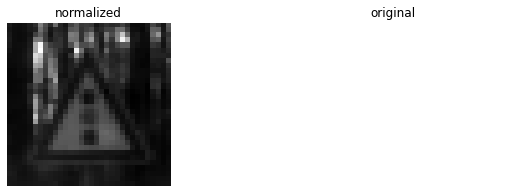

In [16]:
## Normalize the train and test datasets to (-1,1)
X_train_normalized = (X_train - 128)/128 
X_test_normalized = (X_test - 128)/128
  
print(np.mean(X_train_normalized))
print(np.mean(X_test_normalized))

print("Original shape:", X_train.shape)
print("Normalized shape:", X_train_normalized.shape)
fig, axs = plt.subplots(1,2, figsize=(10, 3))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('normalized')
axs[0].imshow(X_train_normalized[0].squeeze(), cmap='gray')

axs[1].axis('off')
axs[1].set_title('original')

Applied all preprocessing to the data images.
Concatenation start.

In [17]:
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train_normalized.shape[0])
            new_img = X_train_normalized[class_indices[0][i % n_samples]]
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

X, y shapes: (25105, 32, 32, 1) (25105,)
0 : |----|----|----|----|----|----|----|----|----|----|----|----|----|-
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|----|----|----|----|----|----|--
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |----|----|----|----|----|----|
15 : |----|----|----|----|----|----|----|---
16 : |----|----|----|----|----|----|----|----|----|----|--
17 : |----|---
18 : |----|
19 : |----|----|----|----|----|----|----|----|----|----|----|----|----|-
20 : |----|----|----|----|----|----|----|----|----|----|----|--
21 : |----|----|----|----|----|----|----|----|----|----|----|----
22 : |----|----|----|----|----|----|----|----|----|----|----|
23 : |----|----|----|----|----|----|----|----|----|-
24 : |----|----|----|----|----|----|----|----|----|----|----|----|--
25 : 
26 : |----|----|----|----|----|----|----|----|--
27 : |----|----|----|----|----|----|----|----|----|----|----|----|----|
28 : |----|----|----|----|----|----|----|----|----
29 : |----|----|----|----|----|-

Show data image VS dat image with preprocessing

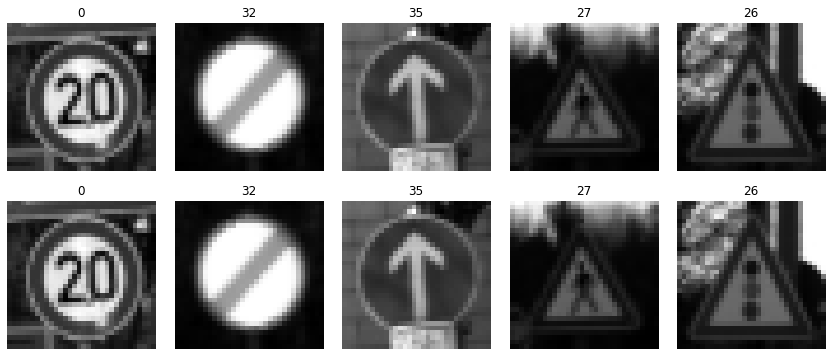

In [18]:
# show comparisons of 5 random augmented data points
choices = list(range(len(input_indices)))
picks = []
for i in range(5):
    rnd_index = np.random.randint(low=0,high=len(choices))
    picks.append(choices.pop(rnd_index))
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(5):
    image = X_train_normalized[input_indices[picks[i]]].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image, cmap = 'gray')
    axs[i].set_title(y_train[input_indices[picks[i]]])
for i in range(5):
    image = X_train_normalized[output_indices[picks[i]]].squeeze()
    axs[i+5].axis('off')
    axs[i+5].imshow(image, cmap = 'gray')
    axs[i+5].set_title(y_train[output_indices[picks[i]]])

In [19]:
## Shuffle the training dataset

from sklearn.utils import shuffle

X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

print('done')

done


In [20]:
# Split validation dataset off from training dataset

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train_normalized, y_train, 
                                                                test_size=0.20, random_state=42)

print("Old X_train size:",len(X_train_normalized))
print("New X_train size:",len(X_train))
print("X_validation size:",len(X_validation))

Old X_train size: 39326
New X_train size: 31460
X_validation size: 7866


In [21]:
import tensorflow as tf

EPOCHS = 60
BATCH_SIZE = 100

print('done')

done


CNN (Convolution Neural Netowkr (modified))

1.5x5 convolution (32x32x1 in, 28x28x6 out) \\\
2.ReLU \\\
3.2x2 max pool (28x28x6 in, 14x14x6 out) \\\
4.5x5 convolution (14x14x6 in, 10x10x16 out) \\\
5.ReLU \\\
6.2x2 max pool (10x10x16 in, 5x5x16 out) \\\
7.5x5 convolution (5x5x6 in, 1x1x400 out) \\\
8.ReLu \\\
9.Flatten layers from numbers 8 (1x1x400 -> 400) and 6 (5x5x16 -> 400) \\\
10.Concatenate flattened layers to a single size-800 layer \\\
11.Dropout layer \\\
12.Fully connected layer (800 in, 43 out)


In [24]:
# from tensorflow.contrib.layers import flatten

def LeNet2(x):    
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    #Activation.
    x = tf.nn.relu(x)
    
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    #Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    #Activation.
    x = tf.nn.relu(x)

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    #Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    #Activation.
    x = tf.nn.relu(x)
    layer3 = x

    #Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    print("layer2flat shape:",layer2flat.get_shape())
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    print("xflat shape:",xflat.get_shape())
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([xflat, layer2flat], 1)
    print("x shape:",x.get_shape())
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    #Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    

    
    return logits

print('done')

done


In [25]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)

print('done')

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

In [ ]:
rate = 0.0009

logits = LeNet2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('done')

Training start

After training is done, it saved as "prototype_model"
With this file and we can use tained model in anytime.

In [ ]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Let's start the training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'prototype_model')
    print("Model saved")

In [ ]:
# Now (drumroll) evaluate the accuracy of the model on the test dataset

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./prototype_model.meta')
    saver2.restore(sess, "./prototype_model")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

In [ ]:
# Reinitialize and re-import if starting a new kernel here
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
import cv2

print('done')

3. Test model on new images
Load the saved model, "prototype_model and run it with new images"

In [ ]:
# Load the images and plot them here.

#reading in an image
import glob
import matplotlib.image as mpimg

fig, axs = plt.subplots(2,4, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./traffic-signs-test/*x.png')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(image)

my_images = np.asarray(my_images)

my_images_gry = np.sum(my_images/3, axis=3, keepdims=True)

my_images_normalized = (my_images_gry - 128)/128 

print(my_images_normalized.shape)

In [ ]:
### Run the predictions here.

my_labels = [3, 11, 1, 12, 38, 34, 18, 25]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./prototype_model.meta')
    saver3.restore(sess, "./prototype_model")
    my_accuracy = evaluate(my_images_normalized, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

In [ ]:
### Visualize the softmax probabilities here.
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./prototype_model.meta')
    saver.restore(sess, "./prototype_model")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images_normalized, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: my_images_normalized, keep_prob: 1.0})

    
    fig, axs = plt.subplots(len(my_images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_validation == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_validation[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_validation == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_validation[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_validation == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_validation[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))